<a href="https://colab.research.google.com/github/Marcelle-git/DeepLearningTask/blob/main/DeepLearning_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries

In [1]:
pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 1.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#from keras.layers.normalization import BatchNormalization


Access to my drive because I imported the image dataset in my Google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the zipfile library for extracting the files that I imported on Drive and copy the paths for loading images

In [4]:
#import zipfile


In [5]:
#zip_train = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r')
#zip_train.extractall('/content/drive/MyDrive/Colab Notebooks')
#zip_train.close()

Loading image dataset train and test

In [6]:
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/seg_train/seg_train'
validation_dataset_path = '/content/drive/MyDrive/Colab Notebooks/seg_test/seg_test'

In [7]:
IMG_WIDTH = 150       #Here are the the size of the images
IMG_HEIGHT = 150
BATCH_SIZE = 32       #I define the batch size

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255,       #We apply data augmentation for increasing the size of the dataset and adding rotation or zoom for better generalization of CNN model
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   #classes = ['buildings','forest','glacier', 'mountain', 'sea', 'street'],
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [9]:
train_generator.class_indices      #Overview of the classes presented in the dataset

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [10]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)                                   #We also defined a validation dataset for evaluating the model performance duraing the training
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             #classes = ['buildings','forest','glacier', 'mountain', 'sea', 'street'],
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


In [11]:
labels = {value: key for key, value in train_generator.class_indices.items()}          #We define the labels of the different classes

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


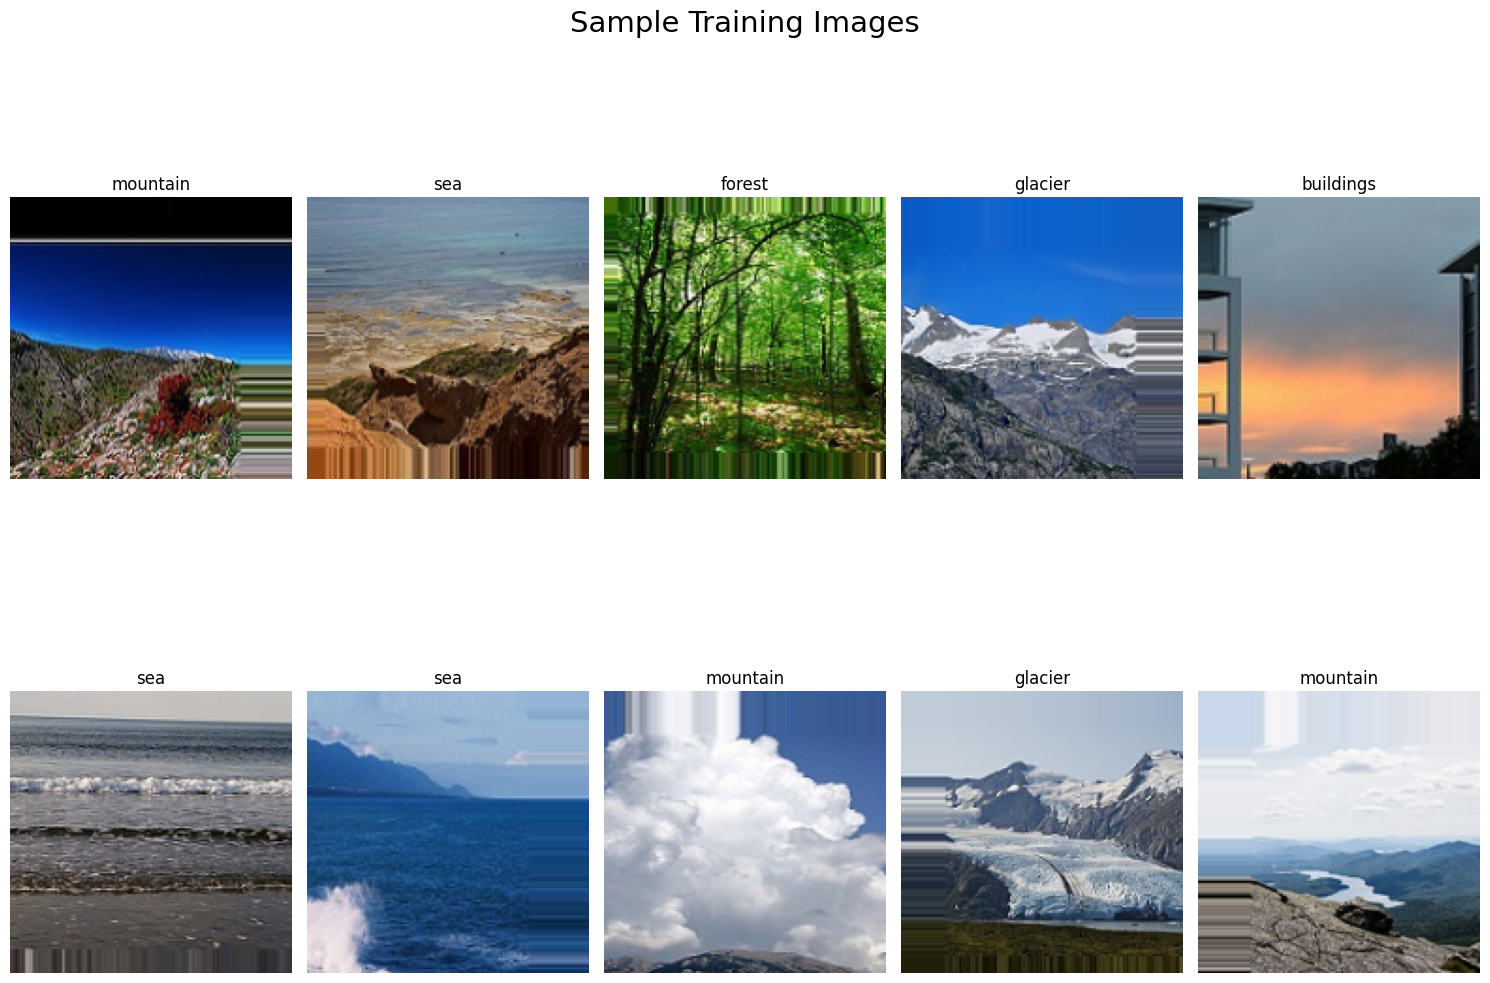

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))         #Overview of the training images
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Building of the model

In [13]:
# Define the model architecture.
# Define the model architecture.
cnn_model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
  keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='valid', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.BatchNormalization(),
  keras.layers.Flatten(),
  keras.layers.Dense(units=256, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=6, activation='softmax')
])


In [14]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [15]:
# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.85,
                                                               final_sparsity=0.95,
                                                               begin_step=2000,
                                                               end_step=5000,frequency=100)
}

In [16]:
cnn_model_for_pruning = prune_low_magnitude(cnn_model, **pruning_params)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)         #We define a callback called Reduce Learning Rate on Plateau;It is used to reduce the learning rate when a metric has stopped improving.

In [18]:
optimizer = Adam(learning_rate=0.001)      #We choose the Adam optimizer for minimizing our loss function which is categoricalcrossentropy

In [19]:
cnn_model_for_pruning.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy']) #Then we compile the model for training step

In [22]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

In [23]:
history = cnn_model_for_pruning.fit(train_generator, epochs=4, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/4
439/439 - 4167s - loss: 2.0534 - accuracy: 0.4840 - val_loss: 1.3519 - val_accuracy: 0.4787 - lr: 0.0010 - 4167s/epoch - 9s/step
Epoch 2/4
439/439 - 2513s - loss: 1.0966 - accuracy: 0.6014 - val_loss: 0.8731 - val_accuracy: 0.6700 - lr: 0.0010 - 2513s/epoch - 6s/step
Epoch 3/4
439/439 - 2571s - loss: 0.9315 - accuracy: 0.6576 - val_loss: 0.9367 - val_accuracy: 0.6100 - lr: 0.0010 - 2571s/epoch - 6s/step
Epoch 4/4
439/439 - 2538s - loss: 0.8542 - accuracy: 0.6937 - val_loss: 0.8409 - val_accuracy: 0.6963 - lr: 0.0010 - 2538s/epoch - 6s/step


In [24]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

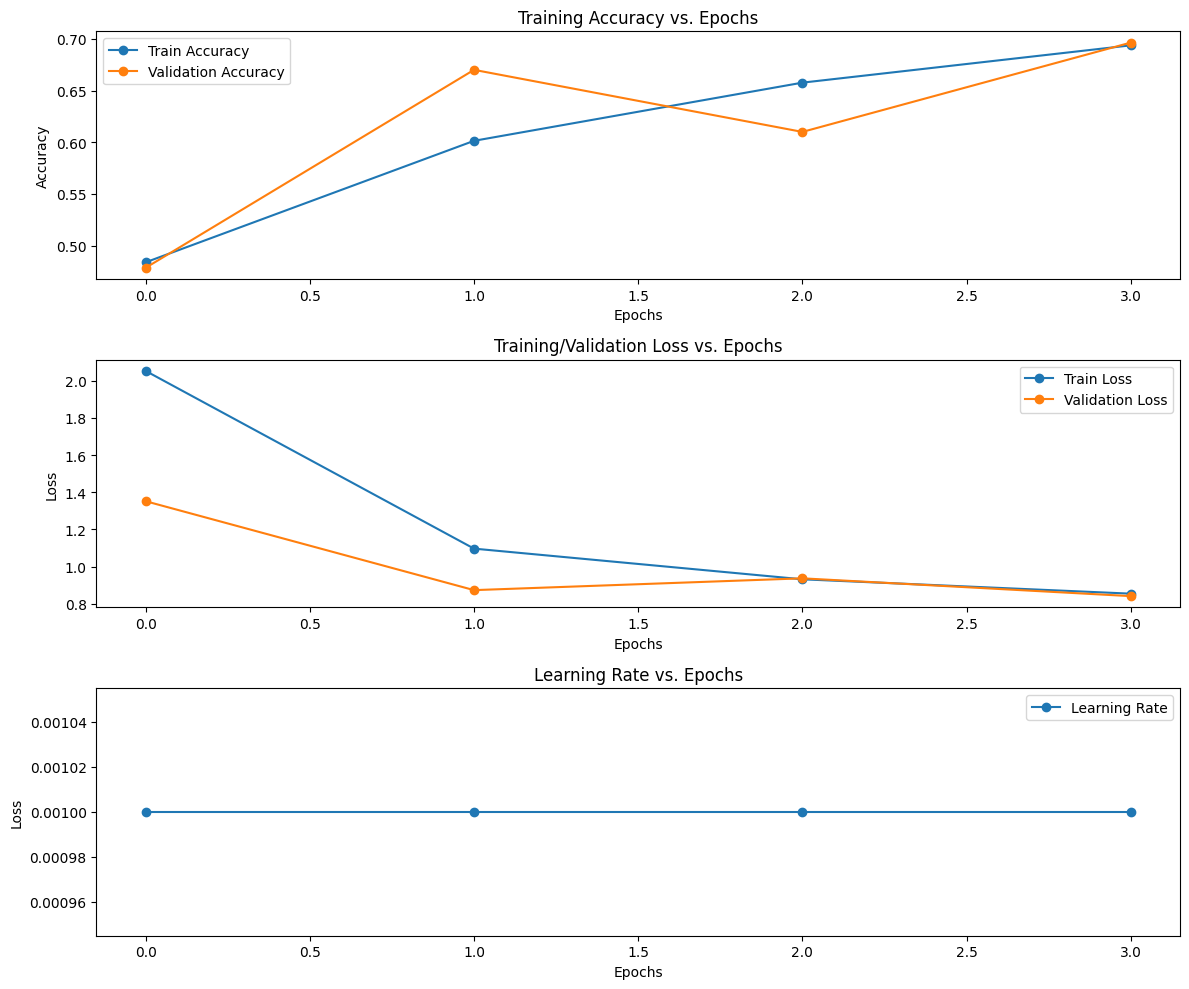

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()


In [26]:
test_dataset = '/content/drive/MyDrive/Colab Notebooks/seg_test/seg_test'   #Loading of the test dataset

In [27]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [28]:
predictions = cnn_model_for_pruning.predict(test_generator) #We make some predictions

94/94 [==============================] - 153s 2s/step


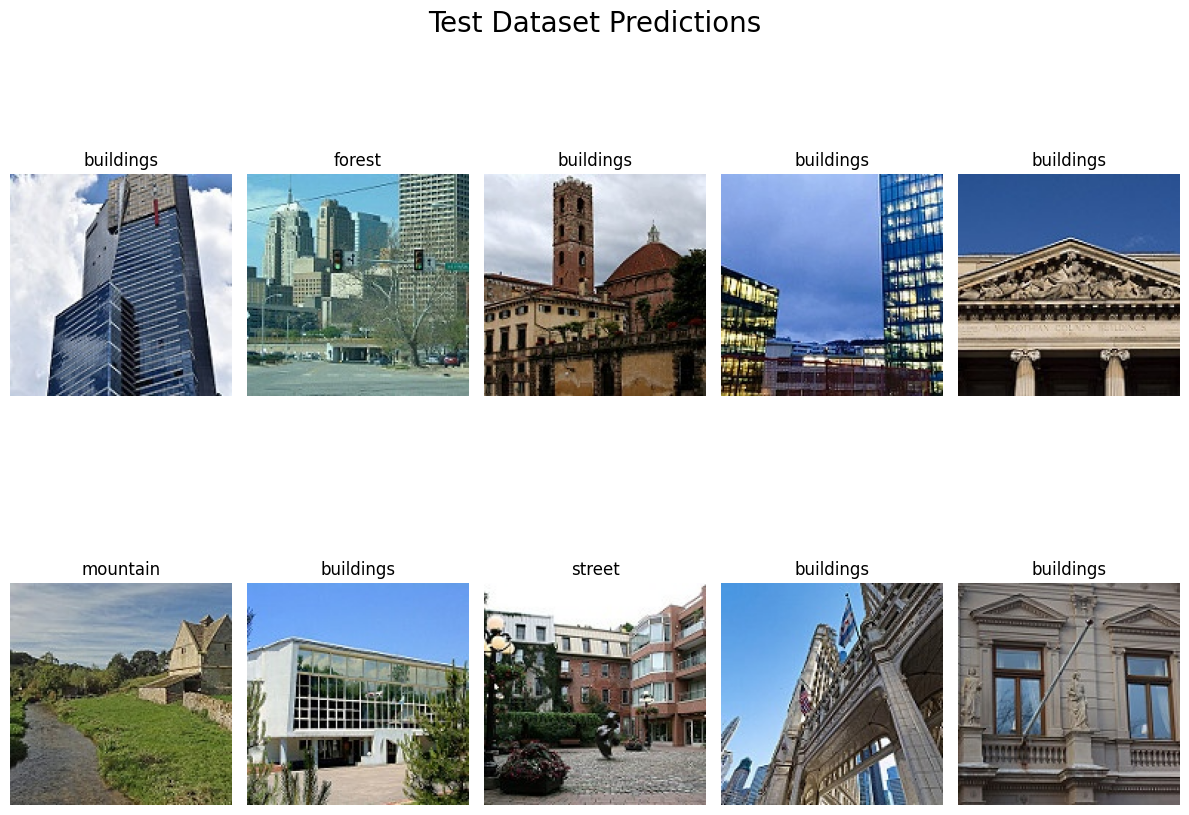

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [30]:
test_loss, test_accuracy = cnn_model_for_pruning.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 143s 2s/step - loss: 0.8409 - accuracy: 0.6963


In [31]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.8408557176589966
Test Accuracy: 0.6963333487510681


In [32]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [33]:
print(classification_report(y_true, y_pred, target_names=labels.values()))   #Then we plot the classification metrics for seeing the performance of the CNN model

              precision    recall  f1-score   support

   buildings       0.80      0.56      0.66       437
      forest       0.73      0.97      0.84       474
     glacier       0.78      0.62      0.69       553
    mountain       0.53      0.87      0.66       525
         sea       0.87      0.42      0.57       510
      street       0.71      0.74      0.72       501

    accuracy                           0.70      3000
   macro avg       0.74      0.70      0.69      3000
weighted avg       0.74      0.70      0.69      3000

